## Stock Price Prediction using Stacked LSTM model

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import Dense, LSTM
from keras.models import Sequential

### Defining the start and end dates for the data

In [2]:
start = "2010-1-1"
end = "2019-12-31"

df = yf.download("AAPL", start=start, end=end)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470741,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481927,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367030,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409361,447610800


In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,70.132500,71.062500,70.092499,71.000000,69.082336,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.148003,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.519920,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.493156,146266000
2019-12-30,72.364998,73.172501,71.305000,72.879997,70.911537,144114400


In [4]:
# Reseting the index
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470741,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481927,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367030,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409361,447610800


In [5]:
df = df[["Close"]]
df.head()

,Close
0,7.643214
1,7.656429
2,7.534643
3,7.520714
4,7.570714


In [6]:
df.shape

(2515, 1)

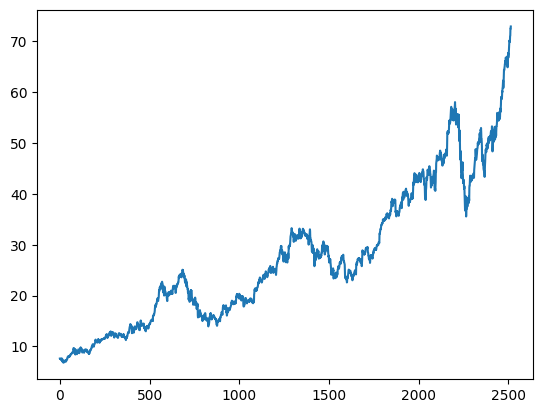

In [7]:
plt.plot(df)

### Scaling the data

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [9]:
df.shape

(2515, 1)

In [10]:
df[0:5]

array([[0.01187932],
       [0.01207947],
       [0.01023482],
       [0.01002384],
       [0.01078118]])

### Splitting the data into training and testing data

As the data is a time series data, we cant just use train_test_split. Therefore we will have to split it manually

In [11]:
training_size = int(len(df) * 0.65)
testing_size = len(df) - training_size

In [12]:
train_data, test_data = df[0:training_size, : ] , df[training_size : len(df), :1]

In [13]:
training_size

1634

In [14]:
testing_size

881

In [15]:
len(train_data)

1634

In [16]:
len(test_data)

881

### Preprocessing the data to convert it into a dataset of dependant and independant variables based on the timesteps

In [17]:
# Creating a function to convert an array into a dataset matrix based on the time step value

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4 
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [19]:
print(X_train)

[[0.01187932 0.01207947 0.01023482 ... 0.02959552 0.02876246 0.02816199]
 [0.01207947 0.01023482 0.01002384 ... 0.02876246 0.02816199 0.0331604 ]
 [0.01023482 0.01002384 0.01078118 ... 0.02816199 0.0331604  0.03506997]
 ...
 [0.25387459 0.26095565 0.26190231 ... 0.25928953 0.25792633 0.26000898]
 [0.26095565 0.26190231 0.2521327  ... 0.25792633 0.26000898 0.24978498]
 [0.26190231 0.2521327  0.25588152 ... 0.26000898 0.24978498 0.24463511]]


In [20]:
print(Y_train)

[0.0331604  0.03506997 0.03720673 ... 0.24978498 0.24463511 0.25050443]


In [21]:
X_train.shape

(1533, 100)

In [22]:
Y_train.shape

(1533,)

### Reshaping the X_train and X_test data into 3 dimensions for the LSTM model

In [23]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
X_train.shape

(1533, 100, 1)

In [25]:
X_test.shape

(780, 100, 1)

### Building the Stacked LSTM Model

In [26]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

c:\Investment Compass Assignment\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compiling the model

In [27]:
model.compile(loss="mean_squared_error", optimizer="adam")

### Checking the model summary

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

### Fitting the model

In [29]:
hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - loss: 0.0184 - val_loss: 0.0039
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 2.5928e-04 - val_loss: 0.0014
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 2.2497e-04 - val_loss: 0.0011
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 2.0109e-04 - val_loss: 0.0012
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 2.1227e-04 - val_loss: 0.0016
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 1.8393e-04 - val_loss: 0.0014
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 1.9424e-04 - val_loss: 0.0013
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 2.0935e-04 - val_loss: 0.0014
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 1.9103e-04 - val_loss: 0.0031
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 2.0778e-04 - val_loss: 0.0015
Epoch 12/100
24/2

### Plotting the learning curve

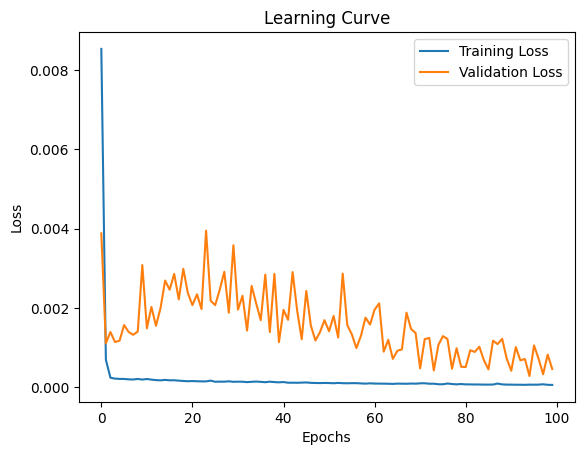

In [30]:
plt.plot(hist.history["loss"], label="Training Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()

### Model Evaluation

In [31]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [32]:
# Inverse Transforming the scaled values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [33]:
# Calculating the RMSE
train_rmse = math.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test, test_predict))

print("Training RMSE: ", train_rmse)
print("Testing RMSE: ", test_rmse)

Training RMSE:  20.78145346240829
Testing RMSE:  44.521403700949634


### Plotting the Predictions against the actual data

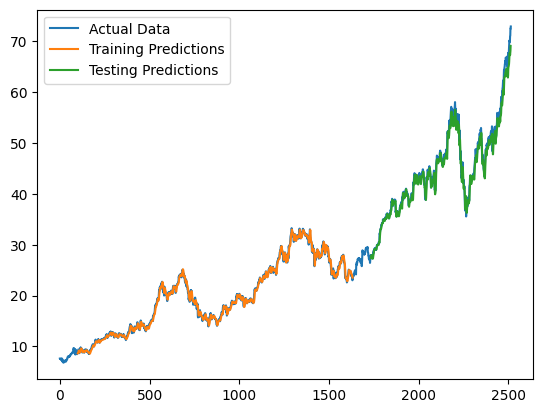

In [34]:
look_back = 100
train_predict_plot = np.empty_like(df)
train_predict_plot[ : , : ] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, : ] = train_predict

test_predict_plot = np.empty_like(df)
test_predict_plot[ : , : ] = np.nan
test_predict_plot[len(train_predict) + (look_back*2)+1 : len(df) - 1, : ] = test_predict

# Plot the baseline and predictions
plt.plot(scaler.inverse_transform(df), label="Actual Data")
plt.plot(train_predict_plot, label="Training Predictions")
plt.plot(test_predict_plot, label="Testing Predictions")
plt.legend()


### Making predictions for the next 3 days

In [35]:
len(test_data)

881

For making predictions of the next 3 days we need the last 100 days as the time step we have taken for the model is 100.

In [36]:
x_input = test_data[(len(test_data) - 100) : ].reshape(1, -1)
x_input.shape

(1, 100)

In [37]:
x_input

array([[0.66643225, 0.65719282, 0.65526159, 0.68741044, 0.66385734,
        0.66003283, 0.67805736, 0.69263606, 0.6926739 , 0.70130751,
        0.70062593, 0.66344081, 0.67801951, 0.66919656, 0.67438428,
        0.68756188, 0.68653952, 0.67502801, 0.68824351, 0.70373097,
        0.70365522, 0.70710111, 0.71668138, 0.74277153, 0.7408782 ,
        0.72444406, 0.72879871, 0.73182806, 0.73966649, 0.73281263,
        0.72058164, 0.72433047, 0.7203923 , 0.73307767, 0.72876086,
        0.72470916, 0.74421049, 0.7465582 , 0.72523929, 0.7322825 ,
        0.75572194, 0.75591128, 0.74583873, 0.75579769, 0.76738489,
        0.79055935, 0.78927184, 0.78718921, 0.78359183, 0.78703771,
        0.79131667, 0.80684198, 0.80475936, 0.81695238, 0.81846709,
        0.8298271 , 0.83918018, 0.81736892, 0.81725533, 0.83808201,
        0.86481595, 0.87117753, 0.86977648, 0.87019296, 0.87848577,
        0.88117439, 0.88897492, 0.88806604, 0.89757062, 0.89064107,
        0.90245546, 0.90752958, 0.90446239, 0.89

In [38]:
# Converting the x_input into a list
temp_input = list(x_input[0])
temp_input

[0.6664322508021759,
 0.6571928244607871,
 0.6552615857655794,
 0.6874104351328685,
 0.6638573429152314,
 0.6600328269843285,
 0.6780573555329387,
 0.6926360582657846,
 0.6926739041652987,
 0.7013075072144649,
 0.7006259343432145,
 0.6634408069005786,
 0.6780195096334245,
 0.6691965615266892,
 0.6743842809800917,
 0.6875618765109244,
 0.6865395172040489,
 0.6750280079518279,
 0.688243507162174,
 0.7037309737233536,
 0.703655224144326,
 0.7071011077400895,
 0.7166813782971028,
 0.7427715325021704,
 0.7408781974864761,
 0.7244440634174493,
 0.7287987108415466,
 0.7318280584226573,
 0.7396664931220314,
 0.7328126296100178,
 0.7205816438070332,
 0.7243304679389075,
 0.7203922987494639,
 0.7330776664666154,
 0.7287608649420324,
 0.7247091580540461,
 0.7442104856036978,
 0.7465582025335591,
 0.7252392895472406,
 0.7322824981168234,
 0.7557219370759196,
 0.7559112821334889,
 0.7458387259827953,
 0.7557976866549472,
 0.7673848877061965,
 0.7905593475886943,
 0.7892718358652228,
 0.787189213571

In [39]:
# Making predictions for the next 3 days and adding it to the past 100 days data stored in temp_input list.

lst_output = []
n_steps = 100
i = 0
while (i < 3):

    if (len(temp_input) > 100):
        x_input = np.array(temp_input[1 : ])  # shifting the 100 values by excluding the 0th idx value and including the new predicted value
        print(f"{i} day input {x_input}")
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(f"{i} day output {yhat}")
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1

    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

print(lst_output)

[0.95763826]
101
1 day input [0.65719282 0.65526159 0.68741044 0.66385734 0.66003283 0.67805736
 0.69263606 0.6926739  0.70130751 0.70062593 0.66344081 0.67801951
 0.66919656 0.67438428 0.68756188 0.68653952 0.67502801 0.68824351
 0.70373097 0.70365522 0.70710111 0.71668138 0.74277153 0.7408782
 0.72444406 0.72879871 0.73182806 0.73966649 0.73281263 0.72058164
 0.72433047 0.7203923  0.73307767 0.72876086 0.72470916 0.74421049
 0.7465582  0.72523929 0.7322825  0.75572194 0.75591128 0.74583873
 0.75579769 0.76738489 0.79055935 0.78927184 0.78718921 0.78359183
 0.78703771 0.79131667 0.80684198 0.80475936 0.81695238 0.81846709
 0.8298271  0.83918018 0.81736892 0.81725533 0.83808201 0.86481595
 0.87117753 0.86977648 0.87019296 0.87848577 0.88117439 0.88897492
 0.88806604 0.89757062 0.89064107 0.90245546 0.90752958 0.90446239
 0.89272369 0.88825545 0.88738447 0.90476527 0.89688905 0.91033168
 0.90809756 0.89639676 0.87856158 0.88723297 0.90177377 0.92119941
 0.90684801 0.91275521 0.9214266  

### Plotting the next 3 days prediction

In [40]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 104)

In [41]:
len(df)

2515

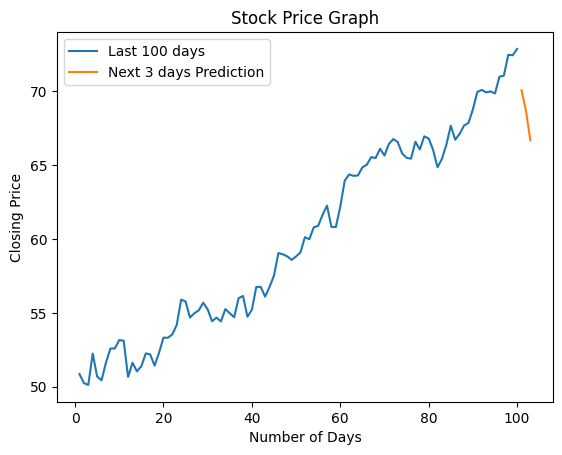

In [42]:
plt.plot(day_new, scaler.inverse_transform(df[(len(df) - 100): ]), label="Last 100 days")
plt.plot(day_pred, scaler.inverse_transform(lst_output), label="Next 3 days Prediction")
plt.xlabel("Number of Days")
plt.ylabel("Closing Price")
plt.title("Stock Price Graph")
plt.legend()

In [43]:
model.save("stock price prediction model.h5")